<a href="https://colab.research.google.com/github/kevingray92/597_Project4_GroupB/blob/checkwithnewCMI_hourly_and_GFS_sfc/Project4_LinearModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt

In [0]:
#gfs = pd.read_csv('./raw_data/GFS_Daily_PredictVars_2010thru2019.csv', index_col = 'Date', usecols = ['Date', 'TMAX', 'TMIN', 'WMAX', 'RTOT'], parse_dates = True)
gfs = pd.read_csv('drive/My Drive/GFS_Daily_PredictVars_2010thru2019.csv', index_col = 'Date', usecols = ['Date', 'TMAX', 'TMIN', 'WMAX', 'RTOT'], parse_dates = True)
# gfsfs = pd.read_csv('./raw_data/GFS_Sfc_42hrFcst_2010thru2019.csv', skiprows=1, index_col = 'Date', parse_dates = True)

#oldobs = pd.read_csv('./raw_data/KCMI_hourly_tidy.csv', index_col = 'Timestamp', parse_dates = True)
oldobs = pd.read_csv('drive/My Drive/KCMI_hourly_tidy.csv', index_col = 'Timestamp', parse_dates = True)
oldobs.index = oldobs.index + pd.DateOffset(hours=12)  # Align times

#obs = pd.read_csv('./raw_data/KCMI_daily_tidy.csv', index_col = 'Date', parse_dates = True)
obs = pd.read_csv('drive/My Drive/KCMI_daily_tidy.csv', index_col = 'Date', parse_dates = True)
obs.index = obs.index + pd.DateOffset(hours=12)  # Align times

#new gfs_sfc file
gfs_sfc = pd.read_csv('drive/My Drive/GFS_Sfc_06Zto06ZAvgMinMax_AdditionalVars_2010thru2019.csv', skiprows=0)
gfs_sfc = gfs_sfc.rename(columns={'Unnamed: 0':'Date'})
gfs_sfc['Date'] = pd.to_datetime(gfs_sfc['Date'])

In [0]:
# Merge and drop all days with missing values 
features = pd.merge(obs.reset_index(), gfs.reset_index(), on = 'Date', how = 'inner')
features = pd.merge(features, oldobs.reset_index(), left_on = 'Date', right_on = 'Timestamp', how = 'inner').drop(columns = 'Timestamp')
features = pd.merge(features, gfs_sfc, how = 'inner')
features.dropna(inplace = True)  # There are some NaNs in the observations

In [27]:
features

,Date,Max Hourly Temp (C),Min Hourly Temp (C),Max Wind Speed (m/s),Daily Precip (mm),TMAX,TMIN,WMAX,RTOT,tmpc,dwpc,mslp,wdir,wspd,skct,pr1h,Avg DWPDEP(C),Min DWPDEP(C),Max DWPDEP(C),Avg LCLD(%),Min LCLD(%),Max LCLD(%),Avg MCLD(%),Min MCLD(%),Max MCLD(%),Avg HCLD(%),Min HCLD(%),Max HCLD(%),Avg PRES(hPa),Min PRES(hPa),Max PRES(hPa)
0,2010-01-01 12:00:00,-11.111111,-16.666667,6.70560,0.0,-11.26,-16.46,7.323933,0.05,-1.975000,-4.183333,1018.208333,279.166667,6.183333,6.000000,0.0,3.530000,2.48,4.95,36.000000,2.0,100.0,0.111111,0.0,1.0,0.000000,0.0,0.0,1000.722222,999.8,1002.0
1,2010-01-02 12:00:00,-14.444444,-20.555556,6.70560,0.0,-10.16,-15.96,4.687217,0.00,-13.325000,-16.933333,1029.316667,286.666667,5.591667,2.250000,0.0,3.194444,2.58,4.43,3.555556,0.0,7.0,0.222222,0.0,1.0,7.375000,0.0,42.0,1000.677778,999.2,1001.8
2,2010-01-03 12:00:00,-12.222222,-21.111111,4.91744,0.0,-9.96,-14.36,5.941380,0.06,-16.525000,-19.816667,1032.991667,296.666667,4.633333,0.000000,0.0,2.160000,1.77,3.11,37.777778,5.0,101.0,40.888889,0.0,96.0,40.222222,0.0,97.0,998.111111,996.5,999.8
3,2010-01-04 12:00:00,-11.666667,-18.888889,8.94080,0.0,-8.46,-12.86,5.685068,0.17,-15.325000,-19.858333,1032.250000,305.833333,3.641667,0.000000,0.0,1.876667,1.57,2.37,96.555556,76.0,100.0,16.333333,0.0,67.0,26.777778,0.0,94.0,996.388889,995.6,997.3
4,2010-01-05 12:00:00,-12.222222,-18.333333,7.15264,0.0,-7.16,-11.06,3.794733,0.77,-14.441667,-17.700000,1028.141667,290.833333,6.300000,1.333333,0.0,1.624444,1.26,2.39,77.125000,1.0,100.0,37.777778,0.0,100.0,36.666667,0.0,100.0,994.244444,991.7,996.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3568,2019-11-16 12:00:00,6.111111,-2.777778,6.25856,0.0,4.64,-1.46,3.847077,1.93,-0.425000,-4.441667,1029.483333,263.333333,2.891667,0.000000,0.0,2.453333,0.97,5.33,3.333333,0.0,30.0,3.666667,0.0,33.0,63.111111,13.0,89.0,986.711111,985.3,987.4
3569,2019-11-17 12:00:00,7.222222,-3.888889,4.02336,0.0,7.44,2.44,4.830114,0.07,2.591667,-1.650000,1027.625000,77.500000,4.533333,0.000000,0.0,1.637778,0.70,3.45,83.111111,7.0,100.0,8.444444,0.0,34.0,83.888889,29.0,100.0,988.366667,987.0,990.6
3570,2019-11-18 12:00:00,4.444444,0.000000,5.81152,1.0,8.64,1.44,6.933974,2.81,2.458333,-0.308333,1016.483333,148.333333,3.091667,0.666667,0.0,4.621111,1.05,8.39,25.333333,0.0,93.0,1.777778,0.0,15.0,59.111111,0.0,100.0,994.588889,991.2,996.5
3573,2019-11-21 12:00:00,13.888889,4.444444,11.62304,5.2,4.44,-1.56,5.852350,0.00,4.725000,2.558333,1022.410000,145.000000,3.375000,3.000000,0.0,4.105556,1.91,5.21,97.666667,79.0,100.0,28.888889,0.0,100.0,5.777778,0.0,52.0,975.233333,970.1,978.8


In [28]:
features.describe()

,Max Hourly Temp (C),Min Hourly Temp (C),Max Wind Speed (m/s),Daily Precip (mm),TMAX,TMIN,WMAX,RTOT,tmpc,dwpc,mslp,wdir,wspd,skct,pr1h,Avg DWPDEP(C),Min DWPDEP(C),Max DWPDEP(C),Avg LCLD(%),Min LCLD(%),Max LCLD(%),Avg MCLD(%),Min MCLD(%),Max MCLD(%),Avg HCLD(%),Min HCLD(%),Max HCLD(%),Avg PRES(hPa),Min PRES(hPa),Max PRES(hPa)
count,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000
mean,17.659630,6.623547,7.596210,2.055976,16.215132,7.257821,5.766963,3.328615,13.999722,6.907353,1017.468269,189.089034,4.996412,2.049873,0.071918,4.061389,1.586237,7.778414,21.701823,4.170133,47.873952,17.542946,1.280969,47.144055,35.884709,8.977957,69.233468,989.308586,986.341664,992.107917
std,11.915530,10.794198,2.932525,5.966827,11.228695,10.028194,2.345599,7.039501,11.949876,10.997128,6.993211,77.741830,2.367252,2.479001,0.321919,2.421164,1.572237,3.992904,27.585566,16.089238,43.106321,21.956615,7.906415,42.570953,30.365677,21.972890,37.917254,6.168224,6.666476,6.075205
min,-21.111111,-26.666667,2.235200,0.000000,-18.760000,-25.060000,1.431782,0.000000,-23.366667,-28.575000,988.527273,0.000000,0.125000,0.000000,-0.100000,0.200000,-0.040000,0.380000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,962.566667,954.800000,970.300000
25%,8.333333,-1.111111,5.811520,0.000000,7.240000,-0.560000,3.992493,0.000000,4.525000,-1.391667,1013.230000,132.727273,3.225000,0.000000,0.000000,2.293333,0.590000,4.850000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.125000,0.000000,38.000000,985.500000,982.600000,988.100000
50%,20.000000,7.777778,7.152640,0.000000,18.340000,8.540000,5.385165,0.310000,16.333333,7.658333,1017.025000,190.000000,4.625000,1.166667,0.000000,3.553333,1.040000,7.370000,7.777778,0.000000,44.000000,7.555556,0.000000,45.000000,31.111111,0.000000,91.000000,989.144444,986.600000,991.500000
75%,27.777778,16.111111,9.387840,0.400000,25.940000,15.540000,7.170077,3.330000,24.491667,16.416667,1021.575000,250.000000,6.475000,2.833333,0.000000,5.317778,2.030000,10.290000,36.222222,0.000000,97.000000,28.875000,0.000000,96.000000,59.222222,1.000000,100.000000,993.055556,990.500000,995.800000
max,37.777778,25.555556,23.246080,85.900000,37.140000,25.040000,16.413714,81.010000,34.716667,26.391667,1044.583333,355.000000,15.258333,9.000000,5.775000,17.476667,13.520000,24.710000,100.000000,100.000000,101.000000,99.555556,97.000000,101.000000,100.000000,100.000000,101.000000,1011.744444,1010.400000,1014.400000


In [0]:
# Add year, month, day as integers 
features['year'] = features['Date'].dt.year
features['month'] = features['Date'].dt.month
features['day'] = features['Date'].dt.day

In [0]:

# The data we will be using to predict the labels
new_features = features.drop(columns = ['Date', 'Max Hourly Temp (C)', 'Min Hourly Temp (C)', 'Max Wind Speed (m/s)', 'Daily Precip (mm)'], axis = 1)
new_features_date = features.drop(columns = ['Max Hourly Temp (C)', 'Min Hourly Temp (C)', 'Max Wind Speed (m/s)', 'Daily Precip (mm)'], axis = 1)

# Save feature list for later
feature_list = list(new_features.columns)

In [31]:
new_features

,TMAX,TMIN,WMAX,RTOT,tmpc,dwpc,mslp,wdir,wspd,skct,pr1h,Avg DWPDEP(C),Min DWPDEP(C),Max DWPDEP(C),Avg LCLD(%),Min LCLD(%),Max LCLD(%),Avg MCLD(%),Min MCLD(%),Max MCLD(%),Avg HCLD(%),Min HCLD(%),Max HCLD(%),Avg PRES(hPa),Min PRES(hPa),Max PRES(hPa),year,month,day
0,-11.26,-16.46,7.323933,0.05,-1.975000,-4.183333,1018.208333,279.166667,6.183333,6.000000,0.0,3.530000,2.48,4.95,36.000000,2.0,100.0,0.111111,0.0,1.0,0.000000,0.0,0.0,1000.722222,999.8,1002.0,2010,1,1
1,-10.16,-15.96,4.687217,0.00,-13.325000,-16.933333,1029.316667,286.666667,5.591667,2.250000,0.0,3.194444,2.58,4.43,3.555556,0.0,7.0,0.222222,0.0,1.0,7.375000,0.0,42.0,1000.677778,999.2,1001.8,2010,1,2
2,-9.96,-14.36,5.941380,0.06,-16.525000,-19.816667,1032.991667,296.666667,4.633333,0.000000,0.0,2.160000,1.77,3.11,37.777778,5.0,101.0,40.888889,0.0,96.0,40.222222,0.0,97.0,998.111111,996.5,999.8,2010,1,3
3,-8.46,-12.86,5.685068,0.17,-15.325000,-19.858333,1032.250000,305.833333,3.641667,0.000000,0.0,1.876667,1.57,2.37,96.555556,76.0,100.0,16.333333,0.0,67.0,26.777778,0.0,94.0,996.388889,995.6,997.3,2010,1,4
4,-7.16,-11.06,3.794733,0.77,-14.441667,-17.700000,1028.141667,290.833333,6.300000,1.333333,0.0,1.624444,1.26,2.39,77.125000,1.0,100.0,37.777778,0.0,100.0,36.666667,0.0,100.0,994.244444,991.7,996.0,2010,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3568,4.64,-1.46,3.847077,1.93,-0.425000,-4.441667,1029.483333,263.333333,2.891667,0.000000,0.0,2.453333,0.97,5.33,3.333333,0.0,30.0,3.666667,0.0,33.0,63.111111,13.0,89.0,986.711111,985.3,987.4,2019,11,16
3569,7.44,2.44,4.830114,0.07,2.591667,-1.650000,1027.625000,77.500000,4.533333,0.000000,0.0,1.637778,0.70,3.45,83.111111,7.0,100.0,8.444444,0.0,34.0,83.888889,29.0,100.0,988.366667,987.0,990.6,2019,11,17
3570,8.64,1.44,6.933974,2.81,2.458333,-0.308333,1016.483333,148.333333,3.091667,0.666667,0.0,4.621111,1.05,8.39,25.333333,0.0,93.0,1.777778,0.0,15.0,59.111111,0.0,100.0,994.588889,991.2,996.5,2019,11,18
3573,4.44,-1.56,5.852350,0.00,4.725000,2.558333,1022.410000,145.000000,3.375000,3.000000,0.0,4.105556,1.91,5.21,97.666667,79.0,100.0,28.888889,0.0,100.0,5.777778,0.0,52.0,975.233333,970.1,978.8,2019,11,21


## Linear Regression with multiple variables; TMAX

In [0]:
# Get the verification data for training and for testing
test_dates = np.array(new_features_date.query('year == 2019')['Date'])
train_verification = np.array(features.query('year < 2019')['Max Hourly Temp (C)'])
test_verification = np.array(features.query('year == 2019')['Max Hourly Temp (C)'])

In [37]:
# Import and set up the model
from sklearn.linear_model import LinearRegression
lrmax = LinearRegression(fit_intercept=True)

column_names = ['TMAX','TMIN','tmpc','Avg LCLD(%)','Avg MCLD(%)','Avg HCLD(%)'] # Choose the columns we want to use in the regression!!!
train_vars = new_features.query('year < 2019')[column_names] # Get the columns for training
test_vars = new_features.query('year == 2019')[column_names] # Get the columns for testing

lrmax.fit(train_vars, train_verification) # Fit the model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [38]:
# Run the model to get predictions during the test period
predictions = lrmax.predict(test_vars)

# Print out the root mean square error (rmse), model slope, and model intercept
# Let's check how well the GFS forecast does. This will be our 'base prediction'
print('Baseline Root Mean Square Error:', round(sqrt(mean_squared_error(test_verification, new_features.query('year == 2019')['TMAX'].values)), 2), 'degrees C.')
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_verification, predictions)), 2), 'degrees C.')
print("Model slope:    ", lrmax.coef_[0])
print("Model intercept:", lrmax.intercept_)

Baseline Root Mean Square Error: 4.5 degrees C.
Root Mean Square Error: 3.23 degrees C.
Model slope:     0.3522108405426687
Model intercept: 4.1603271668034765


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


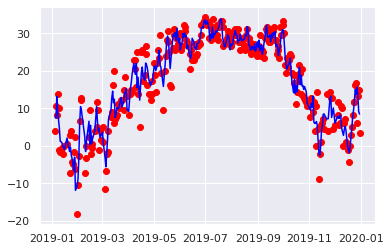

In [12]:
# Make a plot of obs during the test period (red dots) and model prediction during the test period (blue line)
plt.scatter(test_dates, test_verification, c='red')
plt.plot(test_dates, predictions, c='blue')

### Linear Regression with multiple variables; TMIN

In [0]:
# Get the verification data for training and for testing
test_dates = np.array(new_features_date.query('year == 2019')['Date'])
train_verification = np.array(features.query('year < 2019')['Min Hourly Temp (C)'])
test_verification = np.array(features.query('year == 2019')['Min Hourly Temp (C)'])

In [42]:
# Import and set up the model
from sklearn.linear_model import LinearRegression
lrmax = LinearRegression(fit_intercept=True)

column_names = ['TMAX','TMIN','tmpc'] # Choose the columns we want to use in the regression!!!
train_vars = new_features.query('year < 2019')[column_names] # Get the columns for training
test_vars = new_features.query('year == 2019')[column_names] # Get the columns for testing

lrmax.fit(train_vars, train_verification) # Fit the model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [43]:
# Run the model to get predictions during the test period
predictions = lrmax.predict(test_vars)

# Print out the root mean square error (rmse), model slope, and model intercept
print('Baseline Root Mean Square Error:', round(sqrt(mean_squared_error(test_verification, new_features.query('year == 2019')['TMIN'].values)), 2), 'degrees C.')
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_verification, predictions)), 2), 'degrees C.')
print("Model slope:    ", lrmax.coef_[0])
print("Model intercept:", lrmax.intercept_)

Baseline Root Mean Square Error: 4.18 degrees C.
Root Mean Square Error: 3.11 degrees C.
Model slope:     -0.00885765197046887
Model intercept: -3.5722993297758983


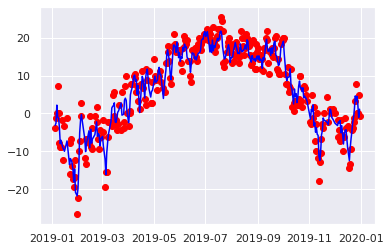

In [16]:
# Make a plot of obs during the test period (red dots) and model prediction during the test period (blue line)
plt.scatter(test_dates, test_verification, c='red')
plt.plot(test_dates, predictions, c='blue')

### Linear Regression with multiple variables; Max Wind Speed

In [0]:
# Get the verification data for training and for testing
test_dates = np.array(new_features_date.query('year == 2019')['Date'])
train_verification = np.array(features.query('year < 2019')['Max Wind Speed (m/s)'])
test_verification = np.array(features.query('year == 2019')['Max Wind Speed (m/s)'])

In [18]:
# Import and set up the model
from sklearn.linear_model import LinearRegression
lrmax = LinearRegression(fit_intercept=True)

column_names = ['WMAX','wspd'] # Choose the columns we want to use in the regression!!!
train_vars = new_features.query('year < 2019')[column_names] # Get the columns for training
test_vars = new_features.query('year == 2019')[column_names] # Get the columns for testing

lrmax.fit(train_vars, train_verification) # Fit the model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [19]:
# Run the model to get predictions during the test period
predictions = lrmax.predict(test_vars)

# Print out the root mean square error (rmse), model slope, and model intercept
print('Baseline Root Mean Square Error:', round(sqrt(mean_squared_error(test_verification, new_features.query('year == 2019')['WMAX'].values)), 2), 'm/s.')
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_verification, predictions)), 2), 'm/s.')
print("Model slope:    ", lrmax.coef_[0])
print("Model intercept:", lrmax.intercept_)

Baseline Root Mean Square Error: 3.34 m/s.
Root Mean Square Error: 2.62 m/s.
Model slope:     0.47394511541951384
Model intercept: 3.075835480614166


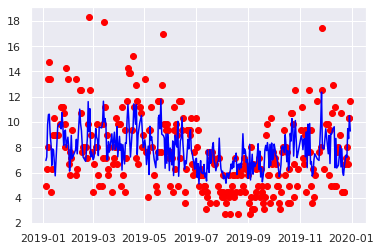

In [20]:
# Make a plot of obs during the test period (red dots) and model prediction during the test period (blue line)
plt.scatter(test_dates, test_verification, c='red')
plt.plot(test_dates, predictions, c='blue')

### Linear Regression with multiple variables; Total Precipitation

In [0]:
# Get the verification data for training and for testing
test_dates = np.array(new_features_date.query('year == 2019')['Date'])
train_verification = np.array(features.query('year < 2019')['Daily Precip (mm)'])
test_verification = np.array(features.query('year == 2019')['Daily Precip (mm)'])

In [22]:
# Import and set up the model
from sklearn.linear_model import LinearRegression
lrmax = LinearRegression(fit_intercept=True)

column_names = ['RTOT','dwpc','mslp','skct'] # Choose the columns we want to use in the regression!!!
train_vars = new_features.query('year < 2019')[column_names] # Get the columns for training
test_vars = new_features.query('year == 2019')[column_names] # Get the columns for testing

lrmax.fit(train_vars, train_verification) # Fit the model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [23]:
# Run the model to get predictions during the test period
predictions = lrmax.predict(test_vars)

# Print out the root mean square error (rmse), model slope, and model intercept
print('Baseline Root Mean Square Error:', round(sqrt(mean_squared_error(test_verification, new_features.query('year == 2019')['RTOT'].values)), 2), 'mm.')
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_verification, predictions)), 2), 'mm.')
print("Model slope:    ", lrmax.coef_[0])
print("Model intercept:", lrmax.intercept_)

Baseline Root Mean Square Error: 8.58 mm.
Root Mean Square Error: 4.88 mm.
Model slope:     0.060139244605312586
Model intercept: -5.209994095045092


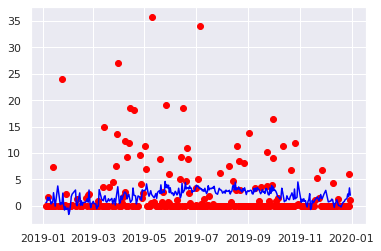

In [24]:
# Make a plot of obs during the test period (red dots) and model prediction during the test period (blue line)
plt.scatter(test_dates, test_verification, c='red')
plt.plot(test_dates, predictions, c='blue')